In [15]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from shapely.geometry import box
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal
from femwell.visualization import plot_domains

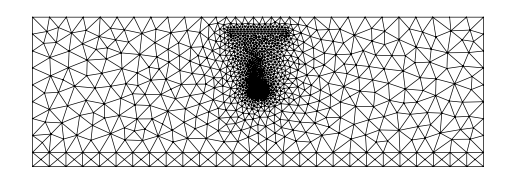

In [16]:
w_sim = 16
h_clad = 2.8
h_box = 2
h_wafer = 0.5

# waveguide parameters
w_core = 0.5
h_core = 0.22

# heater parameters
h_heater = 0.14
w_heater = 2
d_heater = 2 + h_core/2 + h_heater/2# distance between heater and waveguide

# Build mesh grid
core = box(-w_core/2, -h_core/2, w_core/2, h_core/2)
heater = box(-w_heater/2, -h_heater/2 + d_heater, w_heater/2, h_heater/2 + d_heater)
clad_box = box(-w_sim / 2, -h_core/2 - h_box, w_sim/2, -h_core/2 + h_clad)
wafer = box(-w_sim/2, -h_core/2 -h_box - h_wafer, w_sim/2, -h_core/2 - h_box)


polygons = OrderedDict(
    bottom = LineString(  # boundary
        [
            (-w_sim/2, -h_core/2 - h_box - h_wafer),
            (w_sim/2, -h_core/2 - h_box - h_wafer),
        ]
    ),
    core = core,
    heater = heater,
    clad_box = clad_box,
    wafer = wafer,
)

resolutions = dict(
    core = {"resolution": 0.04, "distance": 1},
    clad_box = {"resolution": 0.6, "distance":1},
    heater = {"resolution": 0.1, "distance":1},
)

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()

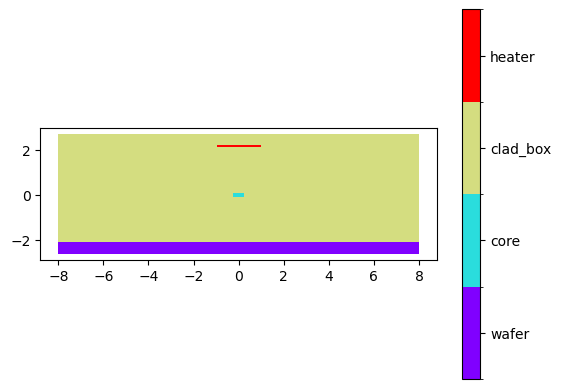

In [17]:
plot_domains(mesh)
plt.show()

 90%|█████████ | 9/10 [00:02<00:00,  3.52it/s]

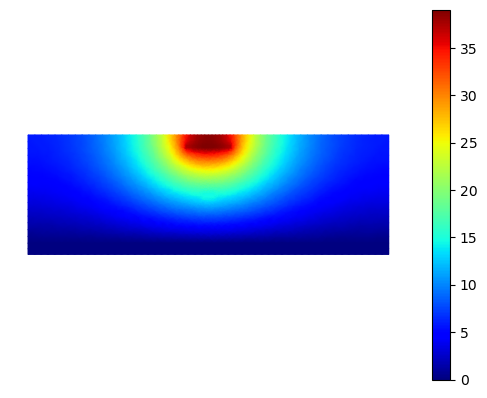

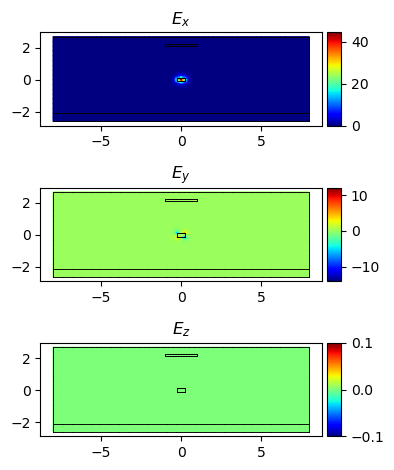

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


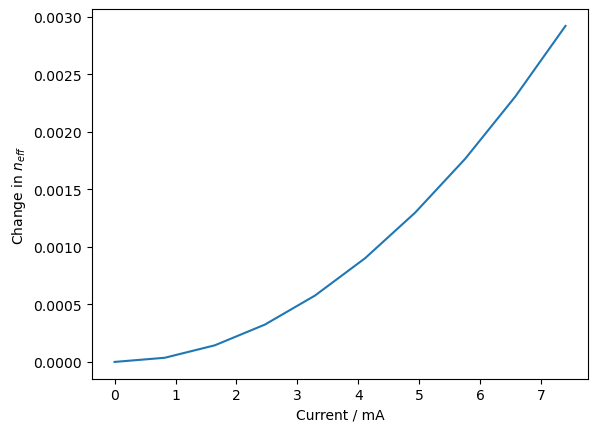

In [18]:
currents = np.linspace(0.0, 7.4e-3, 10)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": 90,
        "clad_box": 1.38,
        "heater": 28,
        "wafer": 148,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *=1e-12 #(1/um^2)

    basis, temperature = solve_thermal(
        basis0, 
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom":0},
    )

    if current_density == current_densities[-1]:
        basis.plot(temperature, shading = "gouraud", colorbar = True)
        plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2 # 1.00e-5: electro-optic coefficient
    epsilon[basis0.get_dofs(elements="core")] = (
        3.4777 + 1.86e-4*temperature0[basis0.get_dofs(elements="core")]
    ) ** 2

    modes = compute_modes(basis0, epsilon, wavelength = 1.55, num_modes=1)

    if current_density == current_densities[-1]:
        modes[0].show(modes[0].E.real)

    neffs.append(np.real(modes[0].n_eff))

plt.plot(currents*1e3, neffs[:] - neffs[0])
plt.xlabel("Current / mA")
plt.ylabel(r"Change in $n_{eff}$")
plt.show()